### Bidirectional LSTM Model Training with Hyperparameter Tuning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install scikeras


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install --upgrade scikeras scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
## Loading Necessary Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [8]:
# Load memmap version of huge array
X = np.load(r"D:\ProgonsAI\milestone_2\week_4\Day_16\rolling_window_sequences.npy", mmap_mode='r')

metadata = pd.read_csv(r"D:\ProgonsAI\milestone_2\week_4\Day_16\sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (152559, 30, 66)
y shape: (152559,)


In [9]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [10]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

MemoryError: Unable to allocate 1.80 GiB for an array with shape (122047, 30, 66) and data type float64

In [11]:
# Create index array
indices = np.arange(len(X))

# Split indices instead of splitting the array
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

print("Train size:", len(train_idx))
print("Val size:", len(val_idx))


Train size: 122047
Val size: 30512


In [12]:
def train_generator():
    for i in train_idx:
        yield X[i], y[i]

def val_generator():
    for i in val_idx:
        yield X[i], y[i]

# Build dataset pipeline
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(30,66), dtype=tf.float64),
        tf.TensorSpec(shape=(), dtype=tf.float64),
    )
).batch(64).prefetch(2)

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_signature=(
        tf.TensorSpec(shape=(30,66), dtype=tf.float64),
        tf.TensorSpec(shape=(), dtype=tf.float64),
    )
).batch(64).prefetch(2)

print("Datasets created successfully!")


Datasets created successfully!


In [13]:
def train_generator():
    for i in train_idx:
        yield X[i], y[i]

def val_generator():
    for i in val_idx:
        yield X[i], y[i]

# Build dataset pipeline
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(30,66), dtype=tf.float64),
        tf.TensorSpec(shape=(), dtype=tf.float64),
    )
).batch(64).prefetch(2)

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_signature=(
        tf.TensorSpec(shape=(30,66), dtype=tf.float64),
        tf.TensorSpec(shape=(), dtype=tf.float64),
    )
).batch(64).prefetch(2)

print("Datasets created successfully!")


Datasets created successfully!


In [15]:
# Build model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(30,66)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(0.001), loss='mse')

# Mentor callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', monitor='val_loss', save_best_only=True, verbose=1
)

# Train safely on full dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt],
    epochs=50
)

print("Training Completed!")


Epoch 1/50
   1906/Unknown 23s 11ms/step - loss: 25292.0485
Epoch 1: val_loss improved from None to 11485.69629, saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - loss: 19445.2734 - val_loss: 11485.6963 - learning_rate: 0.0010
Epoch 2/50
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10340.2772
Epoch 2: val_loss improved from 11485.69629 to 8152.06885, saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 56s 29ms/step - loss: 9484.2256 - val_loss: 8152.0688 - learning_rate: 0.0010
Epoch 3/50
1906/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6449.0040
Epoch 3: val_loss improved from 8152.06885 to 4181.52588, saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 69s 36ms/step - loss: 5435.4346 - val_loss: 4181.5259 - learning_rate: 0.0010
Epoch 4/50
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4178.0171
Epoch 4: val_loss improved from 4181.52588 to 3740.26343, saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
model_ckpt = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define your create_model function (unchanged)
def create_model(lstm_units=64, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=False),
                      input_shape=(X.shape[1], X.shape[2])),
        Dropout(dropout_rate),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Wrap the Keras model with scikeras wrapper without setting params yet
model = KerasRegressor(model=create_model, verbose=0)

# Use 'model__' prefix for model hyperparameters in param_grid
param_grid = {
    'model__lstm_units': [64, 128],
    'model__dropout_rate': [0.3, 0.5],
    'model__learning_rate': [0.001, 0.0001],
    'batch_size': [32],
    'epochs': [30],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_result = grid.fit(
    X_train, y_train,
    callbacks=[early_stopping, reduce_lr, model_ckpt],
    validation_split=0.2,
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

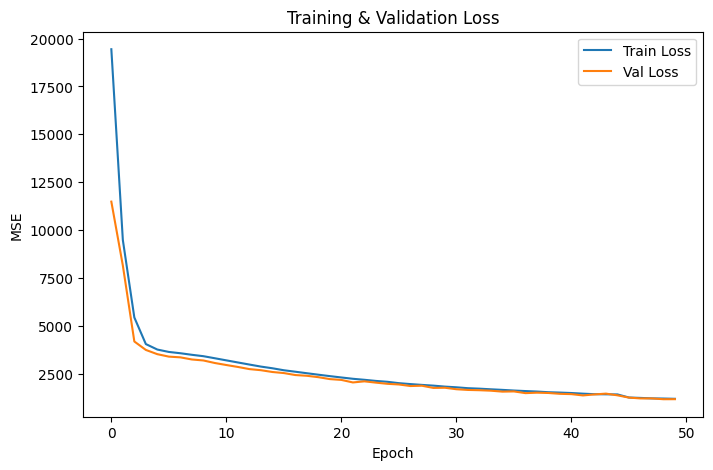

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


In [18]:
model.save("final_model.keras")


In [16]:
# Best params and score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

NameError: name 'grid_result' is not defined

In [ ]:
# Extract best params
best_params = grid_result.best_params_

# Build model with best params
best_model = create_model(lstm_units=best_params['lstm_units'],
                          dropout_rate=best_params['dropout_rate'],
                          learning_rate=best_params['learning_rate'])

# Train and get history
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'],
                         validation_split=0.2, callbacks=[early_stopping, reduce_lr, model_ckpt])

# Plot the curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [ ]:
# Save the best model
best_model.save('best_model.keras')